# Tully-Fisher Relation of galaxies with known Distances

In [1]:
import os

#from astropy.io import fits
from astropy.table import Table, hstack, join
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as u
#from astropy.wcs import WCS
#from astropy.visualization.wcsaxes import SphericalCircle

#import psycopg2

import numpy as np

# try:
#     import numdifftools as ndt
# except ModuleNotFoundError as e:
#     ! pip install --user numdifftools
#     import numdifftools as ndt
    
from scipy.optimize import minimize, curve_fit

import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
mpl.rc('font', size=12)
#mpl.rc('axes', titlesize='small')
mpl.rc('figure', max_open_warning=0)

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [3]:
h = 1
H0 = 100*h

c = 3e5

q0 = 0.2

## Read in targets

In [4]:
SGA_IDs = [294387, 464075, 630029]

In [5]:
tf_targets = Table.read('cache/tf_targets_everest.fits')
SGA = Table.read('SGA_distances.fits', format = 'fits')

In [6]:
idx_sga_coma = np.in1d(tf_targets['SGA_ID'], SGA_IDs)

sga_table = join(tf_targets[idx_sga_coma], SGA, keys='SGA_ID')
sga_table[:2]

PVTYPE,SGA_ID,TARGETID,FIBER_RA,FIBER_DEC,FIBERSTATUS,TILEID,TARGET_RA,TARGET_DEC,Z,ZERR,SPECTYPE,DELTACHI2,ZWARN,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,DM_Stellar,e_DM_lo_Stellar,e_DM_hi_Stellar,Stellar_Catalog,DM1_SN,e_DM1_SN,DM2_SN,e_DM2_SN,DM3_SN,e_DM3_SN,DM4_SN,e_DM4_SN,DM5_SN,e_DM5_SN,DM6_SN,e_DM6_SN,DM7_SN,e_DM7_SN,SN_Catalog
bytes3,int64,int64,float64,float64,int64,int64,float64,float64,float64,float64,bytes6,float64,int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,bytes16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,bytes24
TFT,294387,1070095925248001,183.545486931535,-0.821581014453435,0,76,183.54550321013,-0.821572881819896,1.447811116976,0.000129134659278205,GALAXY,3.17801080644131,4,SGA-2020 294387,PGC039073,39073,183.547164,-0.831551,SABc,171.72,0.7780365,0.561048,0.024841517,23.520481,15.437,False,LEDA-20181114,106169,PGC039073,1,True,183.547164,-0.831551,0.7780365,1836m007,183.5471939888577,-0.8316111360355423,1.2215545,SB26,170.44017,0.5814847,183.54718532704396,-0.8315369651746233,30.07738,12.846199,12.395062,11.759229,8.509257,11.53522,14.766707,18.282831,22.028744,25.829937,29.480642,33.008987,36.646637,16.52693,15.968272,15.577775,16.17626,15.640676,15.267396,15.939795,15.423002,15.057729,15.767317,15.26203,14.904332,15.642654,15.141757,14.787272,15.55682,15.060615,14.709526,15.498996,15.00487,14.656994,15.462121,14.968573,14.623675,15.437742,14.945529,14.603001,0.038360342,0.061051294,0.059315868,0.09041882,0.07770962,0.099839635,0.10327726,0.10800127,0.1

## Calculate the rotational velocities

And store those at $0.33R_{26}$

Also, remove those with a velocity > 5000 km/s

In [7]:
rmag = []
rmag_err = []
abs_mag = []
abs_mag_err = []
vmax = []
dvmax = []

for i, sga_id in enumerate(SGA_IDs):
    # if sga_id == 474614:
    #     print('skipped')
    #     continue
    galaxy_list = sga_table[sga_table['SGA_ID'] == sga_id]
    print
    #print(i+1, sga_id)
    
    is_sga_galaxy = (galaxy_list['TARGETID'] > 30000000000000000) & (galaxy_list['TARGETID'] < 40000000000000000)
    
    sga_galaxy = galaxy_list[is_sga_galaxy]
    tf_list = galaxy_list[~is_sga_galaxy]
    
    if np.sum(is_sga_galaxy) > 1:
        sga_galaxy = sga_galaxy[0]
    
    targetid = int(sga_galaxy['TARGETID'])
    center = SkyCoord(sga_galaxy['FIBER_RA'], sga_galaxy['FIBER_DEC'], unit='deg')
    offcenter = SkyCoord(tf_list['FIBER_RA'], tf_list['FIBER_DEC'], unit='deg')
    sep2d = offcenter.separation(center)
    r26 = 0.5 * float(sga_galaxy['D26'])*u.arcmin
    sep_r26 = sep2d.to('arcmin') / r26
    
    zc, zc_err = sga_galaxy['Z'], sga_galaxy['ZERR']
    zt, zt_err = tf_list['Z'], tf_list['ZERR']
    
    dz = np.abs(zt - zc)
    dz_err = np.sqrt(zc_err**2 + zt_err**2)
    
    dv = c * dz
    dv_err = c * dz_err
    
    good_vel = dv < 5000
    
    if np.sum(good_vel) > 0:
        sep_r26 = np.insert(sep_r26[good_vel], 0, 0.)
        dv = np.insert(dv[good_vel], 0, 0.)
        dv_err = np.insert(dv_err[good_vel], 0, 3e5*zc_err)

        # Extract the 0.33xR26 points.
        is_033_r26 = (sep_r26 > 0.3) & (sep_r26 < 0.4)
        if np.sum(is_033_r26) > 0:
            v033 = np.mean(dv[is_033_r26])
            dv033 = np.sqrt(np.sum(dv_err[is_033_r26]**2))

            rmag.append(float(sga_galaxy['R_MAG_SB26']))
            rmag_err.append(float(sga_galaxy['R_MAG_SB26_ERR']))
            vmax.append(v033)
            dvmax.append(dv033)
            # Find absolute magnitude - 5log(h), using h=0.742 (Union2 (2010))
            abs_mag.append(float(sga_galaxy['R_MAG_SB26'] - sga_galaxy['DM1_SN']) - 5*np.log10(0.742))
            abs_mag_err.append(np.sqrt((float(sga_galaxy['R_MAG_SB26_ERR']))**2 + (float(sga_galaxy['e_DM1_SN']))**2))
    
#print('mag:', rmag)
#print('vel:', vmax)
#print('dv:', dvmax)

3


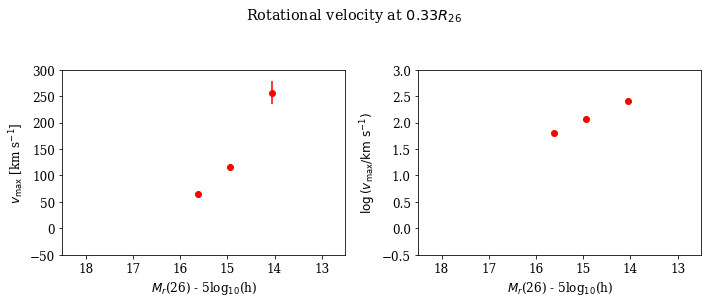

In [8]:
rmag = np.asarray(rmag)
rmag_err = np.asarray(rmag_err)
vmax = np.asarray(vmax)
dvmax = np.asarray(dvmax)
abs_mag = np.asarray(abs_mag)
abs_mag_err = np.asarray(abs_mag_err)

isrmeas = rmag > 0

fig, axes = plt.subplots(1, 2, figsize=(10,4), tight_layout=True)

ax = axes[0]
ax.errorbar(rmag[isrmeas], vmax[isrmeas], xerr = rmag_err[isrmeas], yerr=dvmax[isrmeas], fmt='ro')
ax.set(xlabel='$M_r$(26) - 5log$_{10}$(h)',
       xlim=(18.5, 12.5),
       ylim=(-50,300),
       ylabel='$v_\mathrm{max}$ [km s$^{-1}$]')

ax = axes[1]

log10vmax = np.log10(vmax)
dlog10vmax = 0.434 * dvmax / vmax 

ax.errorbar(rmag[isrmeas], log10vmax[isrmeas], xerr = rmag_err[isrmeas], yerr=dlog10vmax[isrmeas], fmt='ro')
ax.set(xlabel='$M_r$(26) - 5log$_{10}$(h)',
       xlim=(18.5, 12.5),
       ylabel=r'$\log{(v_\mathrm{max} / \mathrm{km~s}^{-1})}$',
       ylim=(-0.5,3))

fig.suptitle(r'Rotational velocity at $0.33R_{26}$', y=1.05)
fig.subplots_adjust(top=0.8)

print(np.sum(isrmeas))

3


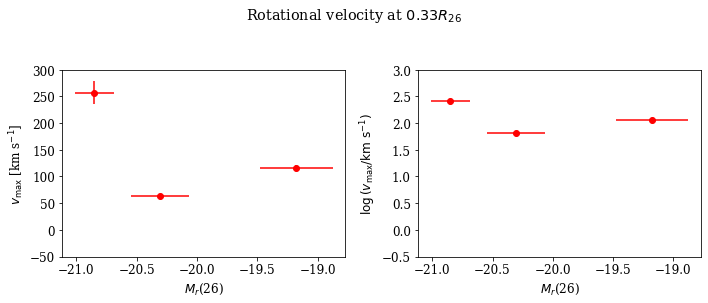

In [9]:
rmag = np.asarray(rmag)
vmax = np.asarray(vmax)
dvmax = np.asarray(dvmax)
abs_mag = np.asarray(abs_mag)
abs_mag_err = np.asarray(abs_mag_err)
# abs_mag_err = np.sqrt()

fig, axes = plt.subplots(1, 2, figsize=(10,4), tight_layout=True)

ax = axes[0]
ax.errorbar(abs_mag, vmax, xerr = abs_mag_err,yerr=dvmax, fmt='ro')
ax.set(xlabel='$M_r$(26)',
       # xlim=(18.5, 12.5),
       ylim=(-50,300),
       ylabel='$v_\mathrm{max}$ [km s$^{-1}$]')

ax = axes[1]

log10vmax = np.log10(vmax)
dlog10vmax = 0.434 * dvmax / vmax 

ax.errorbar(abs_mag[isrmeas], log10vmax[isrmeas], xerr = abs_mag_err[isrmeas],yerr=dlog10vmax[isrmeas], fmt='ro')
ax.set(xlabel='$M_r$(26)',
       # xlim=(18.5, 12.5),
       ylabel=r'$\log{(v_\mathrm{max} / \mathrm{km~s}^{-1})}$',
       ylim=(-0.5,3))

fig.suptitle(r'Rotational velocity at $0.33R_{26}$', y=1.05)
fig.subplots_adjust(top=0.8)

print(np.sum(isrmeas))

## Cuts on inclination angle and morphology

In [17]:
rmag_clean = []
rmag_err_clean = []
vmax_clean = []
dvmax_clean = []
abs_mag_clean = []
abs_mag_err_clean = []
z= []

inc_min = 45*u.degree
cosi_max = np.cos(inc_min.to('radian'))

sga_table['cosi'] = np.sqrt((sga_table['BA']**2 - q0**2)/(1 - q0**2))
sga_table['cosi'][np.isnan(sga_table['cosi'])] = 0 # Objects with b/a < 0.2

#i = 0

for sga_id in np.unique(sga_table['SGA_ID']):
    galaxy_list = sga_table[sga_table['SGA_ID'] == sga_id]
    
    is_sga_galaxy = (galaxy_list['TARGETID'] > 30000000000000000) & (galaxy_list['TARGETID'] < 40000000000000000)
    sga_galaxy = galaxy_list[is_sga_galaxy]
    tf_list = galaxy_list[~is_sga_galaxy]
    
    if np.sum(is_sga_galaxy) > 1:
        sga_galaxy = sga_galaxy[0]
    
    targetid = int(sga_galaxy['TARGETID'])
    
    center = SkyCoord(sga_galaxy['FIBER_RA'], sga_galaxy['FIBER_DEC'], unit='deg')
    offcenter = SkyCoord(tf_list['FIBER_RA'], tf_list['FIBER_DEC'], unit='deg')
    sep2d = offcenter.separation(center)
    
    morphtype = str(sga_galaxy['MORPHTYPE'])
    
    cosi = float(sga_galaxy['cosi'])
    
    r26 = 0.5 * float(sga_galaxy['D26']) * u.arcmin
    sep_r26 = sep2d.to('arcmin') / r26

    # Cut any suspected ellipticals
    if morphtype.startswith('E') or morphtype.startswith('S0') or morphtype.startswith('I'):
        print('{} cut (morphology)'.format(sga_id))
        continue
               
    # Inclination cut
    if cosi > cosi_max:
        print('{} cut (inclination)'.format(sga_id))
        continue
        
    #i += 1
    #print(i, sga_id, cosi)
    
    zc, zc_err = float(sga_galaxy['Z']), float(sga_galaxy['ZERR'])
    zt, zt_err = tf_list['Z'], tf_list['ZERR']
    
    dz = np.abs(zt - zc)
    dz_err = np.sqrt(zc_err**2 + zt_err**2)
    
    dv = 3e5 * dz
    dv_err = 3e5 * dz_err
    
    good_vel = dv < 5000
    
    if np.sum(good_vel) > 0:
    
        sep_r26 = np.insert(sep_r26[good_vel], 0, 0.)
        dv = np.insert(dv[good_vel], 0, 0.)
        dv_err = np.insert(dv_err[good_vel], 0, 3e5*zc_err)

        # Extract the 0.33xR26 points.
        is_033_r26 = (sep_r26 > 0.3) & (sep_r26 < 0.4)
        
        if np.sum(is_033_r26) > 0:
            v033 = np.mean(dv[is_033_r26]) / np.sqrt(1 - cosi**2)
            dv033 = np.sqrt(np.sum(dv_err[is_033_r26]**2)) / np.sqrt(1 - cosi**2)
            z.append(zc)
            rmag_clean.append(float(sga_galaxy['R_MAG_SB26']))
            rmag_err_clean.append(float(sga_galaxy['R_MAG_SB26_ERR']))
            vmax_clean.append(v033)
            dvmax_clean.append(dv033)
            abs_mag_clean.append(float(sga_galaxy['R_MAG_SB26'] - sga_galaxy['DM1_SN'] - 5*np.log10(0.742)))
            abs_mag_err_clean.append(np.sqrt((float(sga_galaxy['R_MAG_SB26_ERR']))**2 + (float(sga_galaxy['e_DM1_SN']))**2))
    
#inComa_sga_table[['SGA_ID', 'BA', 'cosi']].show_in_notebook()
print(len(rmag_clean))

630029 cut (inclination)
2


### Catalogs
294387: Stahl et. al.
464075: 

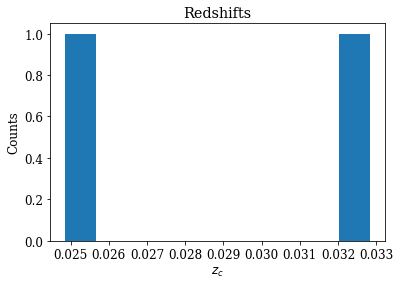

In [18]:
plt.hist(z)
plt.xlabel(r'$z_c$')
plt.ylabel('Counts')
plt.title('Redshifts')
plt.show()

In [ ]:
294387, 464075

In [16]:
sga_table[sga_table['SGA_ID']==464075]

PVTYPE,SGA_ID,TARGETID,FIBER_RA,FIBER_DEC,FIBERSTATUS,TILEID,TARGET_RA,TARGET_DEC,Z,ZERR,SPECTYPE,DELTACHI2,ZWARN,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,DM_Stellar,e_DM_lo_Stellar,e_DM_hi_Stellar,Stellar_Catalog,DM1_SN,e_DM1_SN,DM2_SN,e_DM2_SN,DM3_SN,e_DM3_SN,DM4_SN,e_DM4_SN,DM5_SN,e_DM5_SN,DM6_SN,e_DM6_SN,DM7_SN,e_DM7_SN,SN_Catalog,cosi
bytes3,int64,int64,float64,float64,int64,int64,float64,float64,float64,float64,bytes6,float64,int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,bytes16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,bytes24,float32
TFT,464075,1084254431739904,242.492164247918,43.1225394778083,0,334,242.492201894302,43.1225512964867,0.567282617699403,0.000146986310433262,GALAXY,9.85052530281246,0,SGA-2020 464075,UGC10244,57341,242.48108100000002,43.1290549,Sbc,128.96,1.0423175,0.3019952,0.03288008,24.129482,15.411,False,LEDA-20181114,169351,UGC10244,1,True,242.48108100000002,43.1290549,1.0423175,2424p432,242.48098745213719,43.12912634553939,1.8803749,SB26,128.77156,0.25576675,242.48074521025828,43.12920524001464,33.333332,13.762432,13.33429,6.869408,20.062359,23.480825,26.841143,30.275038,34.482098,39.361794,44.571243,50.888767,56.411247,15.378283,14.3577795,13.665737,15.277042,14.263303,13.620374,15.212705,14.207908,13.586886,15.177601,14.170899,13.565661,15.144904,14.135565,13.546063,15.118075,14.108305,13.528171,15.095903,14.08959,13.514712,15.077272,14.071617,13.503589,15.064306,14.061757,13.50056,0.14993039,0.18158807,0.18825479,0.22639686,0.24359083,0.242874

## Fitting using slope from Coma TFR

In [12]:

def l1norm_noerror(pars, x, y):
    '''
    Linear fit that uses the l1-norm without normalizing by measurement uncertainties.
    '''
    a, b = pars
    return np.sum(np.abs(y - a - b*x))

def fit_tfr2(r, dr, logv, dlogv):
    fmin = 1e99
    a, b = 6, -0.25
    hess_inv = np.ones((2,2))
    succ_res = None
    slope = []
    yint = []
    for i in range(100000):
        x_arr = np.random.normal(r, dr)
        y_arr = np.random.normal(logv, dlogv)
        
        res = minimize(l1norm_noerror, 
                       [a, b], 
                       args=(x_arr, y_arr),# dlogv),
                       method='L-BFGS-B', 
                       bounds=[[-10,10], [-4.2714, -4.2714]])
        
        if res.fun < fmin and res.success:
            # print('Successful fit')
            succ_res = res.copy()
            fmin = res.fun
            a, b = res.x
            hess_inv = res.hess_inv
            slope.append(b)
            yint.append(a)
            
    if succ_res is None:
        print('No successful fits')
    # else:
    #     print(succ_res)
    
    return yint, slope

In [13]:
a, b = fit_tfr2(abs_mag_clean[isrmeas_clean], abs_mag_err_clean[isrmeas_clean], log10vmax_clean[isrmeas_clean], dlog10vmax_clean[isrmeas_clean])

/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx


No successful fits


In [23]:
a

[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]

In [22]:
np.mean(a), np.std(a)

(-1.0, 0.0)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6,4), tight_layout=True)

ax.errorbar(rmag_clean[isrmeas_clean], 
            log10vmax_clean[isrmeas_clean], 
            yerr=dlog10vmax_clean[isrmeas_clean], 
            fmt='ro', 
            alpha=0.7,
            label='Cleaned data, $\cos{(i)}$-corrected')

a_fit, b_fit = np.mean(a), np.mean(b)
r = np.arange(12.5,18.6,0.1)
ax.plot(r, a_fit + b_fit*r, 'r--', alpha=0.8)

ax.set(xlabel='$m_r$(26)',
       xlim=(18.5, 12.5),
       ylabel=r'$\log{(v_\mathrm{max} / \mathrm{km~s}^{-1})}$',
       ylim=(-0.5,3),
       title=r'Rotational velocity at $0.33R_{26}$')

ax.legend(loc='lower right', fontsize=10)

In [29]:
# Log-likelihood
def loglike(theta):
    b = -0.146652
    a, lnf = theta
    model = a + b*x
    inv_sigma2 = 1.0 / (yerr**2 + model**2 * np.exp(2 * lnf))
    
    return -0.5 * (np.sum((y-model)**2 * inv_sigma2 - np.log(inv_sigma2)))

# Define a negative LL for minimizers.
nloglike = lambda theta: -loglike(theta)

In [30]:
p0 = [-2., 0.]

bestfit = minimize(nloglike, p0, method='L-BFGS-B',
                   bounds=((-10.,10.),
                           # (-0.13666, -0.13665),
                           (-20.,20.)))

bestfit

      fun: -6.945516752849134
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.24344978e-06,  2.39808153e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 111
      nit: 22
     njev: 37
   status: 0
  success: True
        x: array([ -0.75655391, -11.16182049])

In [32]:
# hessian = ndt.Hessian(loglike)
# hess_ll = hessian(bestfit.x)
# hess_inv = np.linalg.inv(hess_ll)

# labels = ['y-intercept', 'lnf']

# uncertainty = np.sqrt(np.diag(-hess_inv))
# print('Slope from Coma calibration = -0.13665286 +- 0.0189')
# print('Fit results: ')
# for i in range(2):
#     print('{:<14s} = {:9.4f} +- {:6.4f}'.format(labels[i], bestfit.x[i], uncertainty[i]))

## Fitting using `scipy.optimize.minimize`

Segev's code

In [22]:
def l1norm(pars, x, y, dy):
    '''
    Linear fit that uses the l1-norm (robust against outliers).
    '''
    a, b = pars
    return np.sum(np.abs((y - a - b*x)/dy))

def l1norm_noerror(pars, x, y):
    '''
    Linear fit that uses the l1-norm without normalizing by measurement uncertainties.
    '''
    a, b = pars
    return np.sum(np.abs(y - a - b*x))

def l2norm(pars, x, y, dy):
    '''
    Linear fit that uses the l2-norm
    '''
    a, b = pars
    return np.sum((y - a - b*x)**2/dy**2)

def fit_tfr(r, logv, dlogv):
    fmin = 1e99
    a, b = -0.5, -0.15
    hess_inv = np.ones((2,2))
    
    succ_res = None
    
    # Try a large number of random seeds to ensure a decent fit.
    for i in range(1000):
        _a, _b = np.random.uniform(-1,1), np.random.uniform(-0.146541,-0.146541)
        
        res = minimize(l1norm_noerror, 
                       [_a, _b], 
                       args=(r,logv),# dlogv),
                       method='L-BFGS-B', 
                       bounds=[[-1,1], [-0.146541,-0.146541]])
        
        if res.fun < fmin and res.success:
            # print('Successful fit')
            succ_res = res.copy()
            fmin = res.fun
            a, b = res.x
            hess_inv = res.hess_inv
    
    if succ_res is None:
        print('No successful fits')
    # else:
    #     print(succ_res)
    
    return a, b, hess_inv

In [15]:
abs_mag_clean = np.asarray(abs_mag_clean)
abs_mag_err_clean = np.asarray(abs_mag_err_clean)
vmax_clean = np.asarray(vmax_clean)
dvmax_clean = np.asarray(dvmax_clean)

log10vmax_clean = np.log10(vmax_clean)
dlog10vmax_clean = 0.434 * dvmax_clean / vmax_clean 

a, b, hess_inv = fit_tfr(abs_mag_clean, 
                  log10vmax_clean, 
                  dlog10vmax_clean)

print('Fitted params: a={0}, b={1}'.format(a, b))
print('Slope={0}, y-int={1}'.format(1/b, -a/b))

/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx


{'fun': 0.02661846112007238, 'jac': array([-2.00000007,         nan]), 'nfev': 9, 'njev': 3, 'nit': 1, 'status': 0, 'message': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 'x': array([-0.6667481, -0.146541 ]), 'success': True, 'hess_inv': <2x2 LbfgsInvHessProduct with dtype=float64>}
Fitted params: a=-0.6667480966732697, b=-0.146541
Slope=-6.824028770105294, y-int=-4.549908194111339


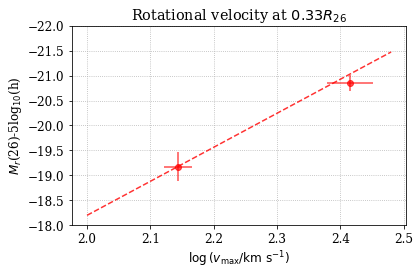

In [18]:
fig, ax = plt.subplots(1,1, figsize=(6,4), tight_layout=True)

ax.errorbar(log10vmax_clean, 
            abs_mag_clean,
            yerr = abs_mag_err_clean,
            xerr=dlog10vmax_clean, 
            fmt='ro', 
            alpha=0.7,
            label='Cleaned data, $\cos{(i)}$-corrected')

# a = -0.75655391
# b = -0.14665

logv = np.arange(2, 2.5, 0.03)
ax.plot(logv, 1/b * (logv - a), 'r--', alpha=0.8)
# ################################################################################


ax.set(ylabel='$M_r$(26)-5log$_{10}$(h)',
       ylim=(-18, -22),
       xlabel=r'$\log{(v_\mathrm{max} / \mathrm{km~s}^{-1})}$',
       # ylim=(-19, -22),
       title=r'Rotational velocity at $0.33R_{26}$')
ax.grid(ls=':')
# ax.legend(loc='upper left', fontsize=10);

# fig.suptitle(r'Max velocity at $0.33\times R_{26}$', y=1.05)
# fig.subplots_adjust(top=0.8)
fig.savefig('tf_dist_04_06_2022.png', dpi=120, transparent=True)

# print(np.sum(isrmeas))

In [24]:
yint = []
for i in range(1000):
    _logv = np.random.normal(log10vmax_clean, dlog10vmax_clean)
    a, b, hess_inv = fit_tfr(abs_mag_clean, 
                                log10vmax_clean, 
                                dlog10vmax_clean)
    yint.append(-a/b)

In [25]:
np.std(yint)

0.09628344291624659

### Iteratively fit and remove objects further than 3$\sigma$

In [10]:
def fit_3sigma(x,y,dy):
    '''
    Iterative linear fit that removes points outside 3sigma of the fit until 
    convergence (no more points removed).
    '''
    
    # Number of points to fit
    N = len(x)
    
    # Initialize variable to store the number of points fit in the last iteration
    N_last = np.inf
    
    while (N < N_last) and (N > 1):
        
        # Update N_last
        N_last = N
        
        # Fit
        a, b, hess_inv = fit_tfr(x, y, dy)
        
        ########################################################################
        # Remove all points that are outside 3-sigma of the fit
        #-----------------------------------------------------------------------
        remove_points = []
        
        for i in range(N):
            ####################################################################
            # Calculate expected value at this point
            #-------------------------------------------------------------------
            y_fit = a + b*x[i]
            ####################################################################
            
            
            ####################################################################
            # Calculate sigma at this point
            #-------------------------------------------------------------------
            random_sample = np.random.multivariate_normal(mean=(a,b), 
                                                          cov=hess_inv.matmat(np.eye(2)), 
                                                          size=1000)
            
            y_random = random_sample[:,0] + random_sample[:,1]*x[i]
            
            std_dev = np.std(y_random)
            ####################################################################
            
            
            if np.abs(y_fit - y[i]) > 3*std_dev:
                remove_points.append(i)
        ########################################################################
        
        
        ########################################################################
        # Update points if needed
        #-----------------------------------------------------------------------
        if len(remove_points) > 0:
            x = np.delete(x, remove_points)
            y = np.delete(y, remove_points)
            dy = np.delete(dy, remove_points)
            
            N = len(x)
        ########################################################################
    
    return a, b, hess_inv

Original
Successful fit
Successful fit
Successful fit
Successful fit
Successful fit
{'fun': 17.23398123162435, 'jac': array([  0.        , -31.90372945]), 'nfev': 198, 'njev': 66, 'nit': 19, 'status': 0, 'message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 'x': array([ 3.92228692, -0.12923591]), 'success': True, 'hess_inv': <2x2 LbfgsInvHessProduct with dtype=float64>}
Successful fit
Successful fit
Successful fit
Successful fit
{'fun': 0.5006566669053467, 'jac': array([  1.92957691, -17.02326678]), 'nfev': 237, 'njev': 79, 'nit': 19, 'status': 0, 'message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 'x': array([ 3.92228712, -0.12923592]), 'success': True, 'hess_inv': <2x2 LbfgsInvHessProduct with dtype=float64>}
3.9222871195548 -0.1292359246954822

Cleaned
Successful fit
Successful fit
Successful fit
Successful fit
Successful fit
Successful fit
Successful fit
{'fun': 9.413012036247746, 'jac': array([  1.99351381, -32.64731776]), 'nfev': 309, 'njev': 103, 'nit': 19, '

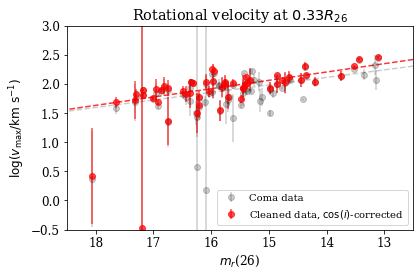

In [11]:
fig, ax = plt.subplots(1,1, figsize=(6,4), tight_layout=True)


################################################################################
# Original data
#-------------------------------------------------------------------------------
print('Original')

ax.errorbar(rmag[isrmeas], 
            log10vmax[isrmeas], 
            yerr=dlog10vmax[isrmeas], 
            fmt='ko', 
            alpha=0.2,
            label='Coma data')

a, b, hess_inv = fit_3sigma(rmag[isrmeas], 
                            log10vmax[isrmeas], 
                            dlog10vmax[isrmeas])
print(a,b)

r = np.arange(12.5,18.6,0.1)
ax.plot(r, a + b*r, 'k--', alpha=0.2)
################################################################################


################################################################################
# Cleaned data
#-------------------------------------------------------------------------------
print('\nCleaned')

rmag_clean = np.asarray(rmag_clean)
vmax_clean = np.asarray(vmax_clean)
dvmax_clean = np.asarray(dvmax_clean)

isrmeas_clean = rmag_clean > 0

log10vmax_clean = np.log10(vmax_clean)
dlog10vmax_clean = 0.434 * dvmax_clean / vmax_clean 

ax.errorbar(rmag_clean[isrmeas_clean], 
            log10vmax_clean[isrmeas_clean], 
            yerr=dlog10vmax_clean[isrmeas_clean], 
            fmt='ro', 
            alpha=0.7,
            label='Cleaned data, $\cos{(i)}$-corrected')

a, b, hess_inv = fit_3sigma(rmag_clean[isrmeas_clean], 
                            log10vmax_clean[isrmeas_clean], 
                            dlog10vmax_clean[isrmeas_clean])
print(a,b)

r = np.arange(12.5,18.6,0.1)
ax.plot(r, a + b*r, 'r--', alpha=0.8)
################################################################################


ax.set(xlabel='$m_r$(26)',
       xlim=(18.5, 12.5),
       ylabel=r'$\log{(v_\mathrm{max} / \mathrm{km~s}^{-1})}$',
       ylim=(-0.5,3),
       title=r'Rotational velocity at $0.33R_{26}$')

ax.legend(loc='lower right', fontsize=10);

# fig.suptitle(r'Max velocity at $0.33\times R_{26}$', y=1.05)
# fig.subplots_adjust(top=0.8)
#fig.savefig('tf_coma.png', dpi=120)

# print(np.sum(isrmeas))

### Make pretty plot of just cleaned data with best fit

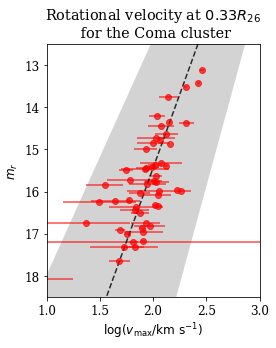

In [12]:
fig, ax = plt.subplots(1,1, figsize=(4,5), tight_layout=True)

rmag_clean = np.asarray(rmag_clean)
vmax_clean = np.asarray(vmax_clean)
dvmax_clean = np.asarray(dvmax_clean)

isrmeas_clean = rmag_clean > 0

log10vmax_clean = np.log10(vmax_clean)
dlog10vmax_clean = 0.434 * dvmax_clean / vmax_clean

r = np.arange(12.5,18.6,0.1)
v = a + b*r

################################################################################
# Compute and plot the uncertainty range around the best fit
#-------------------------------------------------------------------------------
hessian = ndt.Hessian(l1norm)
hess = hessian((a,b), 
               rmag_clean[isrmeas_clean], 
               log10vmax_clean[isrmeas_clean], 
               dlog10vmax_clean[isrmeas_clean])

N_samples = 1000

random_samples = np.random.multivariate_normal(mean=(a,b), 
                                               cov=np.linalg.inv(np.abs(hess)), #hess_inv.matmat(np.eye(2)), 
                                               size=N_samples)

y_samples = np.zeros([1000, len(r)])
for i in range(len(r)):
    y_samples[:,i] = random_samples[:,0] + random_samples[:,1]*r[i]

std_dev = np.std(y_samples, axis=0)

ax.fill_betweenx(r, v-std_dev, v+std_dev, facecolor='lightgray')
################################################################################

ax.plot(v, r, 'k--', alpha=0.8)

ax.errorbar(log10vmax_clean[isrmeas_clean], 
            rmag_clean[isrmeas_clean], 
            xerr=dlog10vmax_clean[isrmeas_clean], 
            fmt='ro', 
            alpha=0.7)

ax.set(ylabel='$m_r$',
       ylim=(18.5, 12.5),
       xlabel=r'$\log{(v_\mathrm{max} / \mathrm{km~s}^{-1})}$',
       xlim=(1,3),
       title='Rotational velocity at $0.33R_{26}$ \n for the Coma cluster');

#plt.savefig('../Figures/PV_TFR_Coma_fitWOerrors_09262021.eps', format='eps', dpi=120);